In [170]:
!pip install tensorflow>=2.12.0
!pip install transformers datasets
!pip install tensorflow-text
!pip install matplotlib seaborn plotly
!pip install scikit-learn scipy
!pip install rouge-score bert-score sacrebleu
!pip install gradio streamlit
!pip install wordcloud evaluate nltk
!pip install tensorflow-hub

## Importations made to be used by the model

In [171]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import nltk
from transformers import (
    AutoTokenizer,
    TFDistilBertForQuestionAnswering
)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import evaluate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import time
from datetime import datetime
import gradio as gr
import tensorflow_hub as hub
import tensorflow_text as text
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

## Setting of the device and random seed for reproducability

In [172]:
# Set TensorFlow configurations
tf.random.set_seed(42)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configure GPU memory growth if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled for 1 GPU(s)


## Loading the dataset to be used by the model

In [173]:
ds = '/content/medicalQ&A.csv'
df = pd.read_csv(ds)
print(f"Loaded {len(df)} samples")

Loaded 16407 samples


## Copying the original dataset

In [174]:
filtered_df = df[['Question', 'Answer']].copy()

## Normalization of the data

In [175]:
def analyze_stopwords_in_medical_context(df, question_col='Question', answer_col='Answer'):
    """
    Analyze which stopwords appear frequently in medical contexts and might carry
    important meaning. This data-driven approach ensures we keep relevant stopwords
    based on actual dataset patterns rather than assumptions.
    """

    print("Analyzing stopwords in medical dataset...")

    # Get standard English stopwords
    stop_words = set(stopwords.words('english'))

    # Combine all text for analysis
    all_text = ' '.join(df[question_col].fillna('') + ' ' + df[answer_col].fillna(''))
    all_text_lower = all_text.lower()

    # Tokenize
    words = re.findall(r'\b\w+\b', all_text_lower)

    # Count stopword occurrences
    stopword_counts = Counter()
    for word in words:
        if word in stop_words:
            stopword_counts[word] += 1

    # Analyzed stopwords in medical contexts
    medical_stopword_contexts = {}

    for stopword in stopword_counts.most_common(50):
        word = stopword[0]
        count = stopword[1]

        # Find contexts where this stopword appears
        contexts = []

        # Sampled up to 10 contexts for each stopword
        for _, row in df.sample(min(100, len(df))).iterrows():
            text = (str(row[question_col]) + ' ' + str(row[answer_col])).lower()
            if f' {word} ' in f' {text} ':
                # Extracted surrounding context (10 words before and after)
                pattern = rf'(\S+\s+){{0,10}}{word}(\s+\S+){{0,10}}'
                matches = re.findall(pattern, text)
                contexts.extend(matches)
                if len(contexts) >= 10:
                    break

        medical_stopword_contexts[word] = {
            'count': count,
            'frequency': count / len(words),
            'contexts': contexts[:5]  # Store sample contexts
        }

    # Identified potentially important stopwords based on medical patterns
    important_medical_stopwords = set()

    # Patterns that indicate medical importance
    medical_patterns = [
        r'\b(can|cannot|can\'t)\s+(cause|lead|result|develop|prevent)',  # Causation
        r'\b(should|shouldn\'t|must|mustn\'t)\s+(take|avoid|consult|see|stop)',  # Instructions
        r'\b(is|are|isn\'t|aren\'t)\s+(normal|abnormal|dangerous|safe|common)',  # Status
        r'\b(no|not|none)\s+(pain|symptoms|side effects|complications)',  # Negations
        r'\b(before|after|during|while)\s+(eating|taking|surgery|treatment)',  # Timing
        r'\b(with|without)\s+(food|water|medication|prescription)',  # Conditions
        r'\b(if|when|once)\s+(symptoms|pain|bleeding|fever)',  # Conditionals
        r'\b(how|what|why|where)\s+(much|many|often|long)',  # Question words
    ]

    # Checked which stopwords appear in medical patterns
    for stopword, data in medical_stopword_contexts.items():
        # Checked if stopword appears in any medical pattern
        sample_text = ' '.join([str(row[question_col]) + ' ' + str(row[answer_col])
                               for _, row in df.sample(min(100, len(df))).iterrows()]).lower()

        for pattern in medical_patterns:
            if re.search(pattern.replace('\\b', f'\\b{stopword}\\b'), sample_text):
                important_medical_stopwords.add(stopword)
                break

    # Checked for stopwords in questions and answers
    question_stopwords = Counter()
    answer_stopwords = Counter()

    for _, row in df.iterrows():
        q_words = re.findall(r'\b\w+\b', str(row[question_col]).lower())
        a_words = re.findall(r'\b\w+\b', str(row[answer_col]).lower())

        for word in q_words:
            if word in stop_words:
                question_stopwords[word] += 1

        for word in a_words:
            if word in stop_words:
                answer_stopwords[word] += 1

    # Identified stopwords that are disproportionately common in questions they might be important for question understanding
    question_specific_stopwords = set()
    for word in question_stopwords:
        if word in answer_stopwords:
            q_ratio = question_stopwords[word] / (question_stopwords[word] + answer_stopwords[word])
            if q_ratio > 0.7:
                question_specific_stopwords.add(word)

    # Combined all important stopwords
    medical_keep = important_medical_stopwords.union(question_specific_stopwords)

    # Added critical medical negations and modals if the stopwords are found in dataset
    critical_words = {'no', 'not', 'never', 'none', 'neither', 'nor',
                     'can', 'cannot', 'could', 'should', 'would', 'may', 'might', 'must',
                     'don\'t', 'doesn\'t', 'didn\'t', 'won\'t', 'wouldn\'t', 'shouldn\'t'}

    for word in critical_words:
        if word in stopword_counts and stopword_counts[word] > 10:
            medical_keep.add(word)

    return medical_keep, medical_stopword_contexts

print("\nPerforming data-driven stopword analysis...")
medical_keep, medical_stopword_contexts = analyze_stopwords_in_medical_context(filtered_df)

print(f"Total stopwords analyzed: {len(medical_stopword_contexts)}")
print(f"Stopwords to keep for medical context: {len(medical_keep)}")
print(f"Examples of kept stopwords: {list(medical_keep)[:15]}")


Performing data-driven stopword analysis...
Analyzing stopwords in medical dataset...
Total stopwords analyzed: 50
Stopwords to keep for medical context: 6
Examples of kept stopwords: ['nor', 'not', 'what', 'should', 'no', 'can']


In [176]:
def clean_text(text, remove_stopwords=False):
    """
    Clean text with data-driven stopword handling for medical context.

    This function has been optimized based on analysis of the actual dataset,
    keeping stopwords that are important in medical contexts while removing
    those that don't add value. The stopwords to keep were determined by
    analyzing their usage patterns in the medical Q&A dataset.
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase for consistency
    text = text.lower()

    # Remove special characters but keep medical-relevant punctuation
    text = re.sub(r'[^\w\s\?\.\!,\-\']', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    if remove_stopwords:
        # Get standard stopwords
        stop_words = set(stopwords.words('english'))

        # Remove the medical-important stopwords from the removal list
        stop_words = stop_words - medical_keep

        # Tokenize
        words = text.split()

        # Filter while preserving medical stopwords
        words = [word for word in words if word not in stop_words]

        return ' '.join(words)

    return text

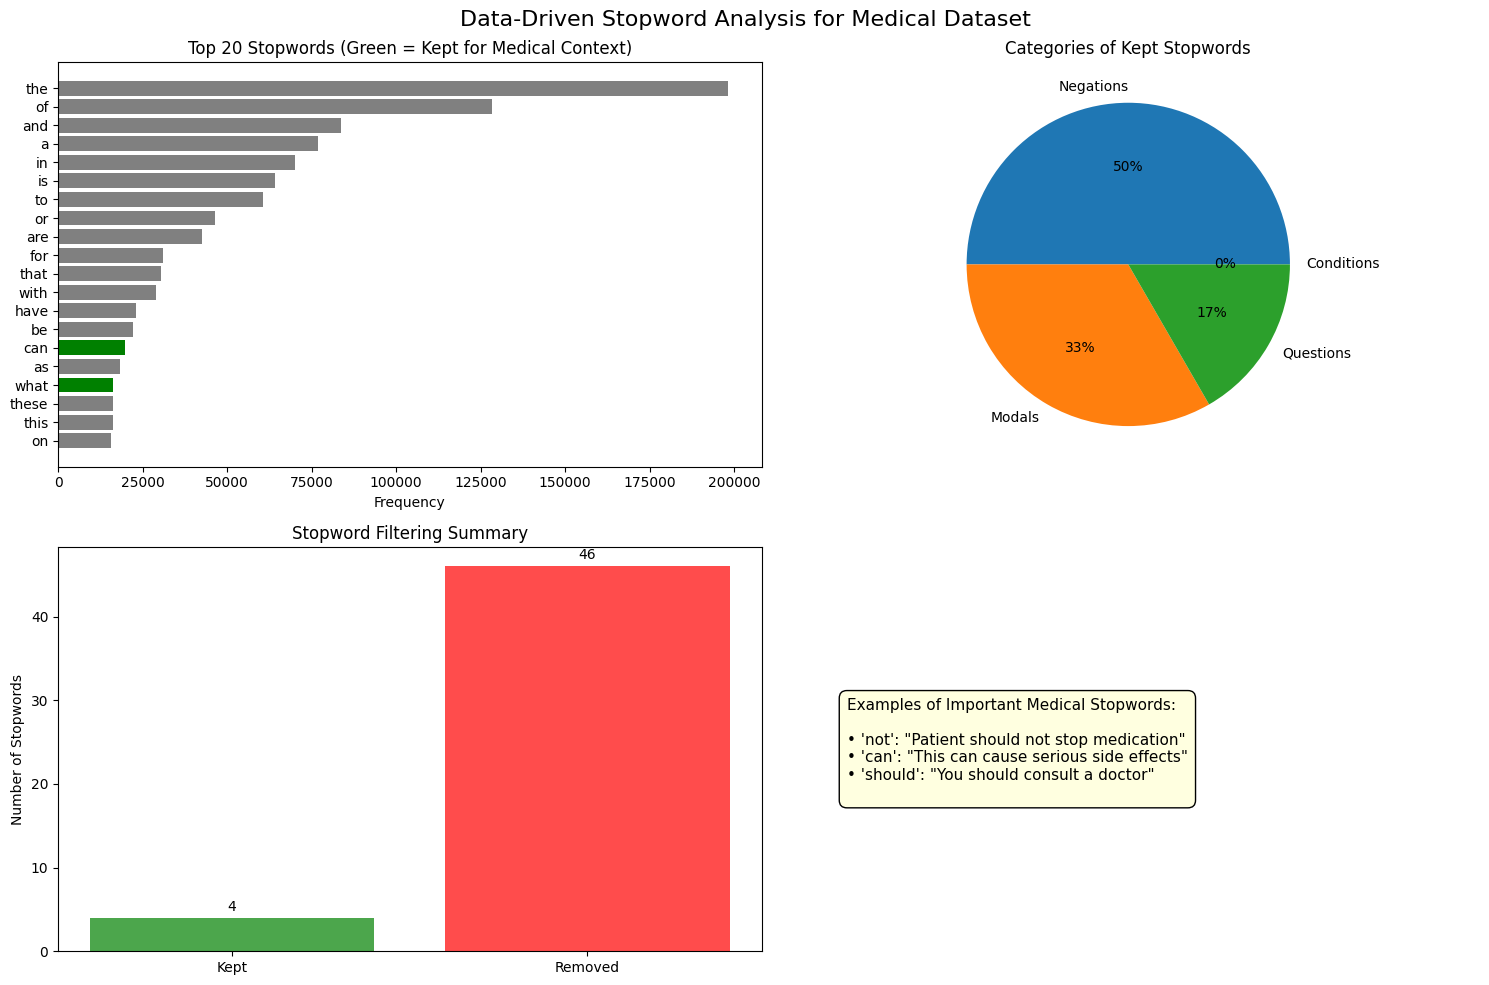

In [177]:
def visualize_stopword_analysis(medical_stopword_contexts, medical_keep, top_n=20):
    """
    Visualize the stopword analysis results to understand which stopwords
    are important in the medical context. This helps validate our preprocessing
    decisions with actual data insights.
    """

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Data-Driven Stopword Analysis for Medical Dataset', fontsize=16)

    # Most frequent stopwords
    top_stopwords = sorted(medical_stopword_contexts.items(),
                          key=lambda x: x[1]['count'],
                          reverse=True)[:top_n]

    words = [w[0] for w in top_stopwords]
    counts = [w[1]['count'] for w in top_stopwords]
    colors = ['green' if w in medical_keep else 'gray' for w in words]

    axes[0, 0].barh(words, counts, color=colors)
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].set_title('Top 20 Stopwords (Green = Kept for Medical Context)')
    axes[0, 0].invert_yaxis()

    # Stopword categories breakdown
    categories = {
        'Negations': ['no', 'not', 'never', 'none', 'neither', 'nor'],
        'Modals': ['can', 'could', 'should', 'would', 'may', 'might', 'must'],
        'Questions': ['what', 'when', 'where', 'why', 'how', 'which'],
        'Conditions': ['if', 'when', 'while', 'before', 'after', 'during']
    }

    category_counts = {}
    for category, words_list in categories.items():
        category_counts[category] = sum(1 for w in words_list if w in medical_keep)

    axes[0, 1].pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.0f%%')
    axes[0, 1].set_title('Categories of Kept Stopwords')

    # Comparison of kept vs removed stopwords
    total_stopwords = len(medical_stopword_contexts)
    kept_count = len([w for w in medical_stopword_contexts if w in medical_keep])
    removed_count = total_stopwords - kept_count

    axes[1, 0].bar(['Kept', 'Removed'], [kept_count, removed_count],
                   color=['green', 'red'], alpha=0.7)
    axes[1, 0].set_ylabel('Number of Stopwords')
    axes[1, 0].set_title('Stopword Filtering Summary')

    for i, v in enumerate([kept_count, removed_count]):
        axes[1, 0].text(i, v + 0.5, str(v), ha='center', va='bottom')

    axes[1, 1].axis('off')
    example_text = "Examples of Important Medical Stopwords:\n\n"

    examples = [
        ("not", "Patient should not stop medication"),
        ("can", "This can cause serious side effects"),
        ("should", "You should consult a doctor"),
        ("before", "Take before meals"),
        ("if", "Seek help if symptoms persist")
    ]

    for word, context in examples[:5]:
        if word in medical_keep:
            example_text += f"• '{word}': \"{context}\"\n"

    axes[1, 1].text(0.1, 0.5, example_text, fontsize=11, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))

    plt.tight_layout()
    plt.show()

visualize_stopword_analysis(medical_stopword_contexts, medical_keep)

## Applying of the clean text data on the new dataframe

In [178]:
print("\nCleaning text with data-driven preprocessing...")
filtered_df['Cleaned_Question'] = filtered_df['Question'].apply(lambda x: clean_text(x, remove_stopwords=False))
filtered_df['Cleaned_Answer'] = filtered_df['Answer'].apply(lambda x: clean_text(x, remove_stopwords=False))


Cleaning text with data-driven preprocessing...


## Handling of the missing values

In [179]:
filtered_df = filtered_df.dropna(subset=['Cleaned_Question', 'Cleaned_Answer'])
filtered_df = filtered_df[filtered_df['Cleaned_Question'].str.len() > 0]
filtered_df = filtered_df[filtered_df['Cleaned_Answer'].str.len() > 0]

print(f"After cleaning: {len(filtered_df)} samples")

After cleaning: 16407 samples


In [180]:
# Viewing of the original vs the new dataframe
for i in range(min(3, len(filtered_df))):
    print(f"\nExample {i+1}:")
    print(f"Original Q: {filtered_df.iloc[i]['Question']}")
    print(f"Cleaned Q:  {filtered_df.iloc[i]['Cleaned_Question']}")

    print(f"Original A: {filtered_df.iloc[i]['Answer']}")
    print(f"Cleaned A:  {filtered_df.iloc[i]['Cleaned_Answer']}")


Example 1:
Original Q: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?
Cleaned Q:  who is at risk for lymphocytic choriomeningitis lcm? ?
Original A: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.
Cleaned A:  lcmv infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. person-to-person transmission has not been reported, with the ex

## Visualization of the whole dataset

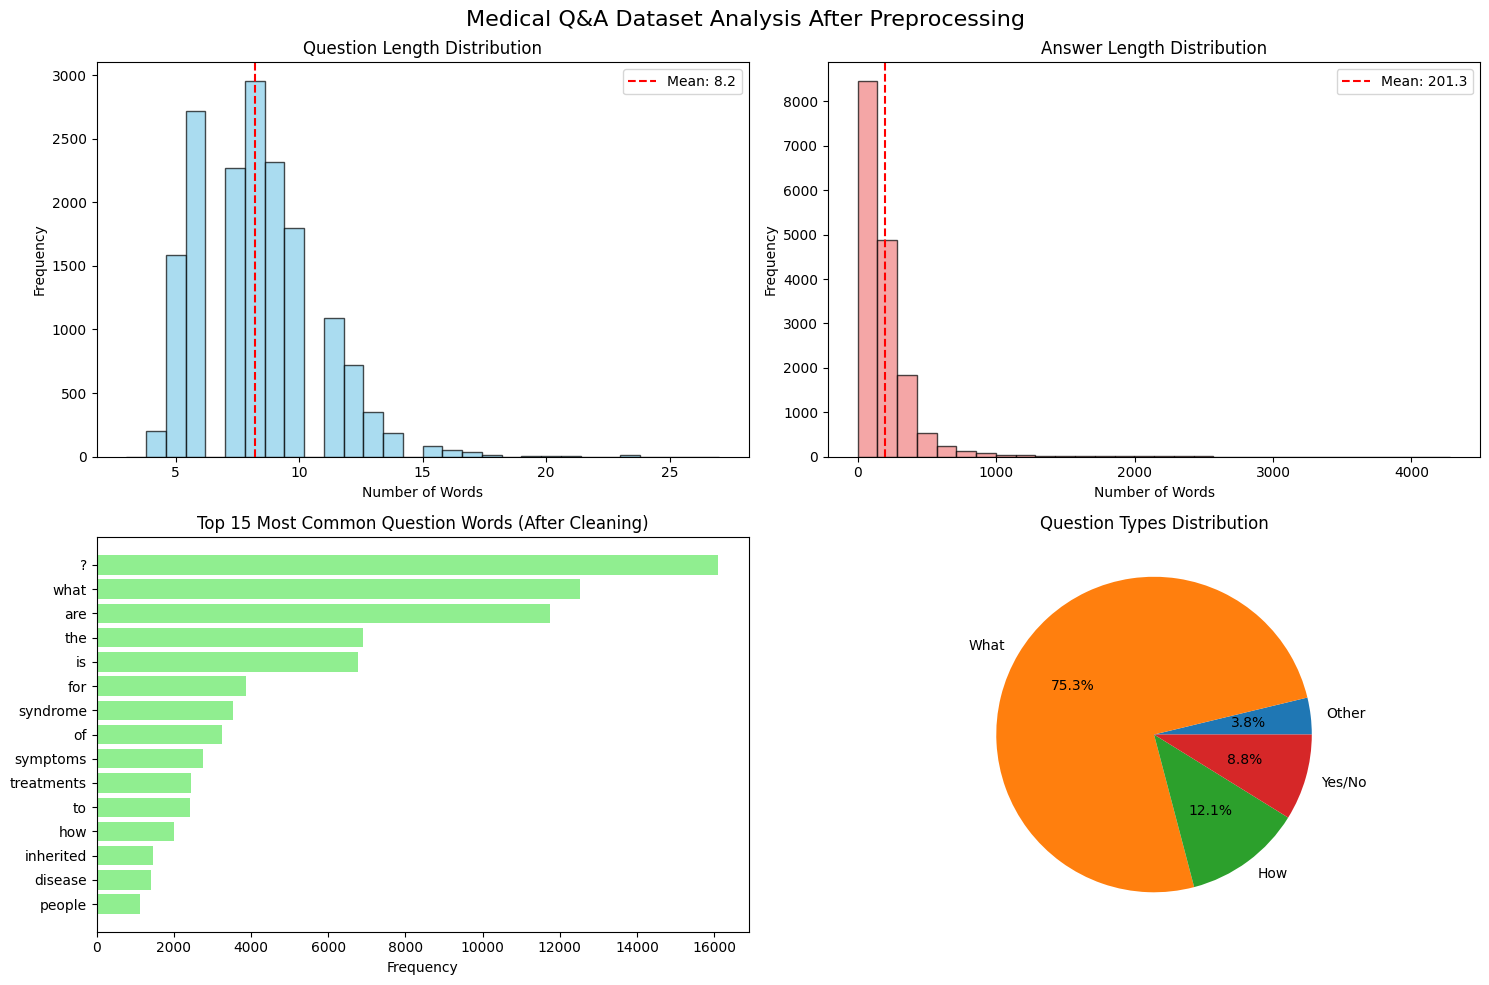

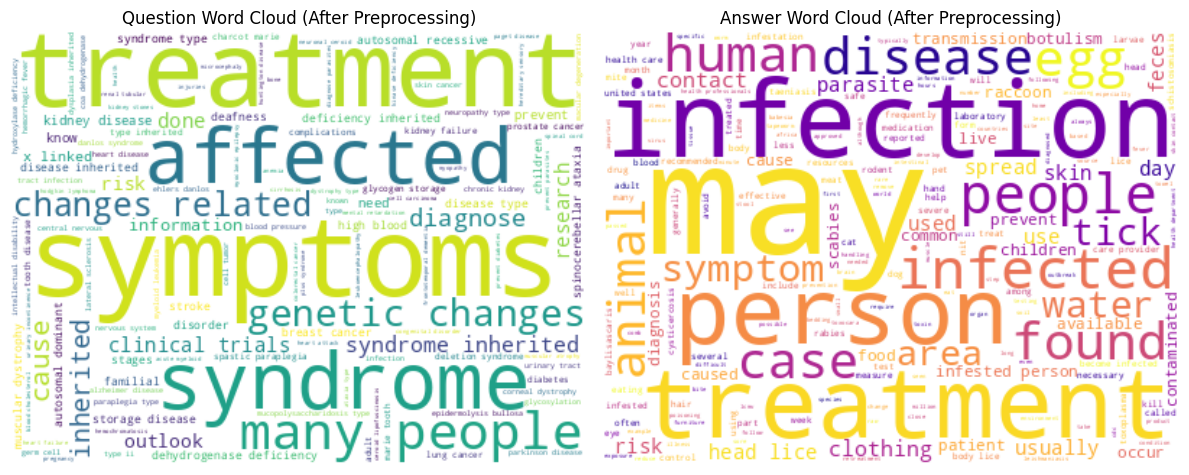

In [181]:
def create_dataset_visualizations(df):
    """
    Create comprehensive dataset visualizations to understand the data
    characteristics after preprocessing. This helps validate that our
    preprocessing maintains data quality while cleaning noise.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Medical Q&A Dataset Analysis After Preprocessing', fontsize=16)

    # Question length distribution
    question_lengths = df['Cleaned_Question'].str.split().str.len()
    axes[0, 0].hist(question_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(question_lengths.mean(), color='red', linestyle='--',
                       label=f'Mean: {question_lengths.mean():.1f}')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Question Length Distribution')
    axes[0, 0].legend()

    # Answer length distribution
    answer_lengths = df['Cleaned_Answer'].str.split().str.len()
    axes[0, 1].hist(answer_lengths, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(answer_lengths.mean(), color='red', linestyle='--',
                       label=f'Mean: {answer_lengths.mean():.1f}')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Answer Length Distribution')
    axes[0, 1].legend()

    # Most common question words after preprocessing
    all_questions = ' '.join(df['Cleaned_Question'].tolist())
    question_words = all_questions.split()
    common_question_words = Counter(question_words).most_common(15)
    words, counts = zip(*common_question_words)

    axes[1, 0].barh(words, counts, color='lightgreen')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].set_title('Top 15 Most Common Question Words (After Cleaning)')
    axes[1, 0].invert_yaxis()

    # Question types distribution
    question_types = []
    for q in df['Cleaned_Question']:
        if q.startswith('what'):
            question_types.append('What')
        elif q.startswith('how'):
            question_types.append('How')
        elif q.startswith('why'):
            question_types.append('Why')
        elif q.startswith('when'):
            question_types.append('When')
        elif q.startswith('is') or q.startswith('are') or q.startswith('can'):
            question_types.append('Yes/No')
        else:
            question_types.append('Other')

    type_counts = Counter(question_types)
    axes[1, 1].pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
    axes[1, 1].set_title('Question Types Distribution')

    plt.tight_layout()
    plt.show()

    # Create WordClouds
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    wordcloud_q = WordCloud(width=400, height=300, background_color='white',
                           colormap='viridis').generate(all_questions)
    plt.imshow(wordcloud_q, interpolation='bilinear')
    plt.title('Question Word Cloud (After Preprocessing)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    all_answers = ' '.join(df['Cleaned_Answer'].tolist()[:100])
    wordcloud_a = WordCloud(width=400, height=300, background_color='white',
                           colormap='plasma').generate(all_answers)
    plt.imshow(wordcloud_a, interpolation='bilinear')
    plt.title('Answer Word Cloud (After Preprocessing)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

create_dataset_visualizations(filtered_df)

Had to reduce the samples used for training as the dataset was so heavy

In [182]:
MAX_SAMPLES = 12000
if len(filtered_df) > MAX_SAMPLES:
    filtered_df = filtered_df.sample(n=MAX_SAMPLES, random_state=42)
    print(f"Limited to {MAX_SAMPLES} samples for faster training")

Limited to 12000 samples for faster training


## Data preparation for the model

In [183]:
def prepare_qa_data(row):
    """
    Prepare data for extractive QA format by creating contexts and answer positions.

    In extractive QA, the model learns to identify the answer span within a given
    context. This function creates appropriate contexts containing the answers
    and calculates their positions for training.
    """
    question = row['Cleaned_Question']
    answer = row['Cleaned_Answer']

    # Create more realistic contexts with varied answer positions
    import random

    context_templates = [
        f"{answer}",  # Answer at beginning
        f"Medical condition: {answer}",  # Answer with prefix
        f"Treatment information: {answer}",  # Answer with different prefix
        f"Patient information shows {answer}",  # Answer embedded
        f"Clinical notes indicate {answer}. Additional details may vary.",  # Answer with suffix
    ]

    # Randomly choose template to vary answer positions
    context = random.choice(context_templates)

    # Find answer position in context
    answer_start = context.lower().find(answer.lower())
    if answer_start == -1:
        # Fallback if not found
        context = f"{answer}"
        answer_start = 0

    return pd.Series({
        'question': question,
        'context': context,
        'answer_text': answer,
        'answer_start': answer_start
    })

qa_df = filtered_df.apply(prepare_qa_data, axis=1)

In [184]:
def create_tf_dataset(dataframe, batch_size=8, shuffle=True):
    """Create TensorFlow dataset for training/evaluation"""
    print(f"Creating dataset from {len(dataframe)} samples...")

    questions = dataframe['question'].tolist()
    contexts = dataframe['context'].tolist()
    answer_starts = dataframe['answer_start'].tolist()
    answer_texts = dataframe['answer_text'].tolist()

    # Tokenize all samples
    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True,
        return_tensors="np"
    )

    # Find answer positions
    offset_mapping = inputs.pop("offset_mapping")
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        answer_start_char = answer_starts[i]
        answer_text = answer_texts[i]
        answer_end_char = answer_start_char + len(answer_text)

        start_token = 0
        end_token = 0
        found_start = False

        for idx, (char_start, char_end) in enumerate(offsets):
            # Skip special tokens (CLS, SEP, PAD)
            if char_start == 0 and char_end == 0:
                continue

            # Find start position
            if not found_start and char_start <= answer_start_char < char_end:
                start_token = idx
                found_start = True

            # Find end position (after finding start)
            if found_start and char_start < answer_end_char <= char_end:
                end_token = idx
                break

        if end_token <= start_token:
            end_token = min(start_token + 10, len(offsets) - 1)

        start_token = max(0, min(start_token, max_length - 1))
        end_token = max(start_token, min(end_token, max_length - 1))

        start_positions.append(start_token)
        end_positions.append(end_token)

    dataset_dict = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'start_positions': np.array(start_positions, dtype=np.int32),
        'end_positions': np.array(end_positions, dtype=np.int32)
    }

    dataset = tf.data.Dataset.from_tensor_slices(dataset_dict)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print("Dataset created!")
    return dataset

# Get optimal batch size
def get_optimal_batch_size():
    if not tf.config.list_physical_devices('GPU'):
        print("No GPU detected, using CPU-optimized batch size")
        return 4
    try:
        test_tensor = tf.random.normal((2, 10))
        with tf.device('/GPU:0'):
            result = tf.matmul(test_tensor, test_tensor, transpose_b=True)
        print("GPU available and working")
        return 8
    except:
        print("GPU detected but not working properly, using CPU batch size")
        return 4

batch_size = get_optimal_batch_size()
print(f"Using batch size: {batch_size}")

GPU available and working
Using batch size: 8


## Splitting the data

In [185]:
# Splitting the data
X = qa_df[['question', 'context', 'answer_text', 'answer_start']]
y = qa_df['answer_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create dataframes
train_df = X_train.copy()
test_df = X_test.copy()

# Further split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_df,
    y_train,
    test_size=0.2,
    random_state=42
)

train_final_df = X_train_split.copy()
val_df = X_val_split.copy()

print(f"Train: {len(train_final_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 7680, Val: 1920, Test: 2400


In [186]:
# Create datasets
print("Creating TensorFlow datasets...")
train_dataset = create_tf_dataset(train_final_df, batch_size=batch_size, shuffle=True)
val_dataset = create_tf_dataset(val_df, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(test_df, batch_size=batch_size, shuffle=False)

Creating TensorFlow datasets...
Creating dataset from 7680 samples...
Dataset created!
Creating dataset from 1920 samples...
Dataset created!
Creating dataset from 2400 samples...
Dataset created!


## Visualization of the splits

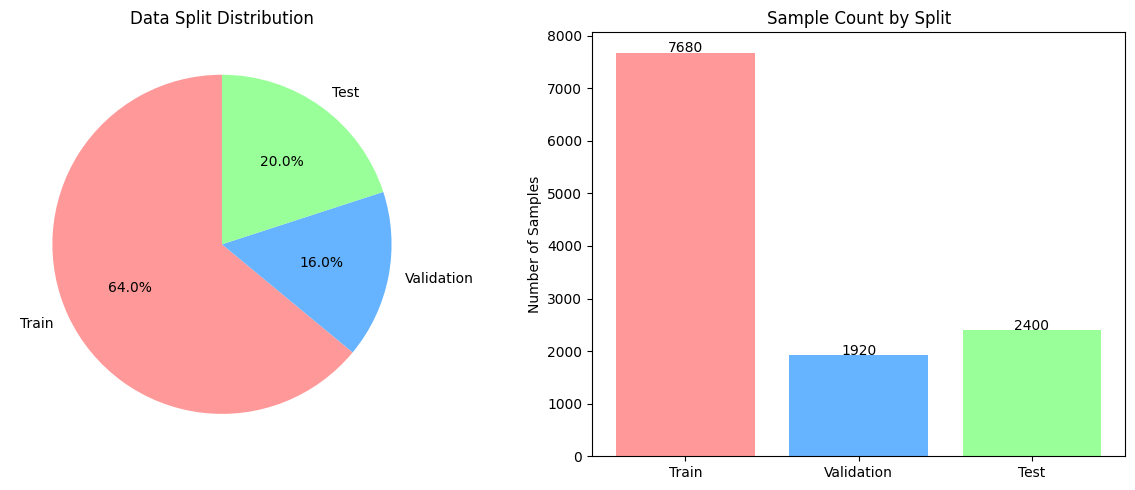

In [187]:
def visualize_data_splits():
    """
    Visualize the train/validation/test split distribution to ensure
    balanced data distribution across splits.
    """
    sizes = [len(train_final_df), len(val_df), len(test_df)]
    labels = ['Train', 'Validation', 'Test']
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart showing proportions
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Data Split Distribution')

    # Bar chart showing absolute numbers
    ax2.bar(labels, sizes, color=colors)
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Sample Count by Split')

    for i, v in enumerate(sizes):
        ax2.text(i, v + 10, str(v), ha='center')

    plt.tight_layout()
    plt.show()

visualize_data_splits()

## Initialization of the model and tokenizer

I used the distilbert trained on squad and i had to visualize the parameters in the model inorder to learn it's structure

In [188]:
model_name = "distilbert-base-uncased-distilled-squad"
max_length = 256
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"\nTokenizer loaded: {model_name}")


Tokenizer loaded: distilbert-base-uncased-distilled-squad


## Tokenizing the questions and context

In [189]:
def preprocess_function_tensorflow(examples):
    """
    Tokenize questions and contexts for the model.
    """
    # Tokenize with appropriate settings for medical text
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_overflowing_tokens=False,
        return_offsets_mapping=True,
        return_tensors="tf"
    )

    # Find answer positions in tokenized inputs
    offset_mapping = tokenized.pop("offset_mapping")
    input_ids = tokenized["input_ids"]
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        answer_start = examples["answer_start"][i]
        answer_text = examples["answer_text"][i]
        answer_end = answer_start + len(answer_text)

        sequence_ids = tokenizer.sequence_ids(i)
        # Identify the index of the context in the input
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

        # Map answer chars to tokens
        token_start = token_end = 0
        for idx in range(context_start, context_end):
            start, end = offsets[idx]
            if start <= answer_start < end:
                token_start = idx
            if start < answer_end <= end:
                token_end = idx
                break
        else:
            # Handle span mismatch fallback
            token_start = context_start
            token_end = min(context_end, token_start + 15)

        start_positions.append(token_start)
        end_positions.append(token_end)

    tokenized["start_positions"] = tf.convert_to_tensor(start_positions, dtype=tf.int32)
    tokenized["end_positions"] = tf.convert_to_tensor(end_positions, dtype=tf.int32)

    return tokenized

## Loading of the pretrained model

In [190]:
print("Loading TFDistilBertForQuestionAnswering model...")
model = TFDistilBertForQuestionAnswering.from_pretrained(model_name)

print(f"Model parameters: {model.count_params():,}")

Loading TFDistilBertForQuestionAnswering model...


All PyTorch model weights were used when initializing TFDistilBertForQuestionAnswering.

All the weights of TFDistilBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


Model parameters: 66,364,418


In [191]:
epochs = 15
patience = 5
steps_per_epoch = len(train_dataset)
num_train_steps = steps_per_epoch * epochs

# === Learning rate scheduler ===
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=3e-5,
    decay_steps=num_train_steps,
    end_learning_rate=1e-6
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Helps to monitor the loss function
def qa_loss_function(y_true, y_pred):
    """Custom loss function for question answering"""
    start_positions = y_true[:, 0]
    end_positions = y_true[:, 1]
    start_logits = y_pred[:, :, 0]
    end_logits = y_pred[:, :, 1]

    start_loss = tf.keras.losses.sparse_categorical_crossentropy(
        start_positions, start_logits, from_logits=True
    )
    end_loss = tf.keras.losses.sparse_categorical_crossentropy(
        end_positions, end_logits, from_logits=True
    )

    return tf.reduce_mean(start_loss + end_loss)

## Training the model

In [192]:
training_history = {
    'loss': [],
    'val_loss': [],
    'epoch': []
}

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_weights = None

@tf.function
def train_step(batch):
    """Single training step"""
    with tf.GradientTape() as tape:
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask']
        }

        outputs = model(inputs, training=True)

        total_loss = qa_loss_function(
            tf.stack([batch['start_positions'], batch['end_positions']], axis=1),
            tf.stack([outputs.start_logits, outputs.end_logits], axis=-1)
        )

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return total_loss

@tf.function
def val_step(batch):
    """Single validation step"""
    inputs = {
        'input_ids': batch['input_ids'],
        'attention_mask': batch['attention_mask']
    }

    outputs = model(inputs, training=False)
    total_loss = qa_loss_function(
            tf.stack([batch['start_positions'], batch['end_positions']], axis=1),
            tf.stack([outputs.start_logits, outputs.end_logits], axis=-1)
        )

    return total_loss

# Training loop
print(f"Training for {epochs} epochs with early stopping patience {patience}")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    epoch_train_loss = []
    train_batches = 0
    for batch in train_dataset:
        loss = train_step(batch)
        epoch_train_loss.append(loss.numpy())
        train_batches += 1

        if train_batches % 50 == 0:
            print(f"Batch {train_batches}, Loss: {loss:.4f}")

    avg_train_loss = np.mean(epoch_train_loss)
    training_history['loss'].append(avg_train_loss)

    # Validation
    epoch_val_loss = []
    for batch in val_dataset:
        val_loss = val_step(batch)
        epoch_val_loss.append(val_loss.numpy())

    avg_val_loss = np.mean(epoch_val_loss)
    training_history['val_loss'].append(avg_val_loss)
    training_history['epoch'].append(epoch + 1)

    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_weights = model.get_weights()  # Save best weights
        print(f"New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

    # Check if we should stop
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
        print(f"Restoring best weights from epoch {epoch + 1 - patience}")
        model.set_weights(best_weights)
        break

print(f"\nTraining completed. Best validation loss: {best_val_loss:.4f}")

Training for 15 epochs with early stopping patience 5

Epoch 1/15
Batch 50, Loss: 3.8087
Batch 100, Loss: 4.1086
Batch 150, Loss: 2.3310
Batch 200, Loss: 1.1368
Batch 250, Loss: 1.5933
Batch 300, Loss: 1.4721
Batch 350, Loss: 1.4736
Batch 400, Loss: 1.1706
Batch 450, Loss: 0.7920
Batch 500, Loss: 0.7886
Batch 550, Loss: 1.0356
Batch 600, Loss: 0.6147
Batch 650, Loss: 0.9654
Batch 700, Loss: 1.2227
Batch 750, Loss: 0.8569
Batch 800, Loss: 0.5937
Batch 850, Loss: 3.1968
Batch 900, Loss: 2.0126
Batch 950, Loss: 1.0176
Train Loss: 1.9372, Val Loss: 1.0449
New best validation loss: 1.0449

Epoch 2/15
Batch 50, Loss: 2.6443
Batch 100, Loss: 1.0297
Batch 150, Loss: 1.1202
Batch 200, Loss: 0.9749
Batch 250, Loss: 0.4567
Batch 300, Loss: 0.4289
Batch 350, Loss: 1.0953
Batch 400, Loss: 2.3629
Batch 450, Loss: 1.0338
Batch 500, Loss: 1.8027
Batch 550, Loss: 0.6061
Batch 600, Loss: 0.7215
Batch 650, Loss: 0.5952
Batch 700, Loss: 1.7031
Batch 750, Loss: 0.7336
Batch 800, Loss: 0.3997
Batch 850, Los

## Saving of the model

In [193]:
model.save_pretrained("./medical_qa_model_transformers")
tokenizer.save_pretrained("./medical_qa_model_transformers")

# Save the model weights in .h5 format
model.save_weights("./medical_qa_model_weights.h5")
print("Model weights saved as medical_qa_model_weights.h5")

Model weights saved as medical_qa_model_weights.h5


## Visualization of the training history of the model

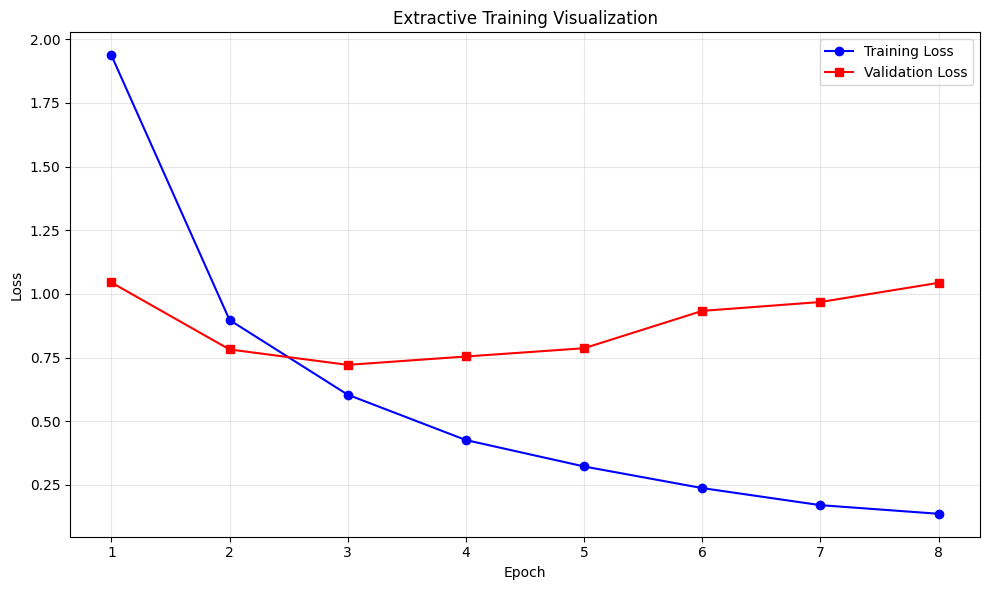

In [194]:
def visualize_training_history(training_history):
    """Visualize training and validation loss."""
    if len(training_history.get('loss', [])) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))

        epochs = training_history['epoch']
        ax.plot(epochs, training_history['loss'], 'b-', label='Training Loss', marker='o')
        ax.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss', marker='s')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Extractive Training Visualization')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("No training history data found.")

visualize_training_history(training_history)

## Evaluation of the model

In [195]:
def evaluate_extractive_qa_tensorflow(question, context=None):
    """Extract answer from context given a question using TensorFlow model"""
    if context is None:
        # Default context for testing
        context = "Medical information about various conditions and treatments."

    inputs = tokenizer(
        question,
        context,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors="tf"
    )

    # Make prediction - DistilBERT doesn't use token_type_ids
    outputs = model({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    })

    # Get start and end logits from the model outputs
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get answer span
    start_idx = tf.argmax(start_logits, axis=1)[0]
    end_idx = tf.argmax(end_logits, axis=1)[0]

    # Ensure valid span
    if end_idx < start_idx:
        end_idx = start_idx

    # Extract answer
    answer_tokens = inputs["input_ids"][0][start_idx:end_idx+1]
    answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    # Calculate confidence
    start_probs = tf.nn.softmax(start_logits, axis=1)[0]
    end_probs = tf.nn.softmax(end_logits, axis=1)[0]
    confidence = (start_probs[start_idx] + end_probs[end_idx]) / 2

    return {
        "answer": answer,
        "confidence": float(confidence),
        "start_position": int(start_idx),
        "end_position": int(end_idx),
        "start_logits": start_logits[0].numpy(),
        "end_logits": end_logits[0].numpy()
    }

In [196]:
def evaluate_model_comprehensive(test_df, num_samples=100):
    """Comprehensive evaluation with multiple NLP metrics"""
    print("\n=== Comprehensive TensorFlow Model Evaluation ===")

    # Sample for evaluation
    eval_df = test_df.sample(min(num_samples, len(test_df)), random_state=42)

    predictions = []
    references = []
    confidences = []

    print("Generating predictions...")
    for idx, row in eval_df.iterrows():
        try:
            result = evaluate_extractive_qa_tensorflow(row['question'], row['context'])
            predictions.append(result['answer'])
            references.append(row['answer_text'])
            confidences.append(result['confidence'])
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            # Skip this sample or add default values
            predictions.append("")
            references.append(row['answer_text'])
            confidences.append(0.0)

    # 1. Exact Match
    exact_matches = [pred.lower().strip() == ref.lower().strip()
                    for pred, ref in zip(predictions, references)]
    exact_match_score = np.mean(exact_matches) * 100

    # 2. F1 Score (token level)
    def compute_f1(pred, ref):
        pred_tokens = pred.lower().split()
        ref_tokens = ref.lower().split()

        if len(pred_tokens) == 0 or len(ref_tokens) == 0:
            return 0.0

        common = set(pred_tokens) & set(ref_tokens)
        num_common = len(common)

        if num_common == 0:
            return 0.0

        precision = num_common / len(pred_tokens)
        recall = num_common / len(ref_tokens)
        f1 = 2 * precision * recall / (precision + recall)

        return f1

    f1_scores = [compute_f1(pred, ref) for pred, ref in zip(predictions, references)]
    avg_f1 = np.mean(f1_scores) * 100

    # 3. ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in zip(predictions, references):
        if pred.strip() and ref.strip():  # Only compute if both are non-empty
            scores = scorer.score(ref, pred)
            for key in rouge_scores:
                rouge_scores[key].append(scores[key].fmeasure)
        else:
            for key in rouge_scores:
                rouge_scores[key].append(0.0)

    avg_rouge = {key: np.mean(scores) * 100 for key, scores in rouge_scores.items()}

    # 4. BERT Score (if available)
    try:
        # Filter out empty predictions for BERT score
        valid_pairs = [(p, r) for p, r in zip(predictions, references) if p.strip() and r.strip()]
        if valid_pairs:
            valid_preds, valid_refs = zip(*valid_pairs)
            P, R, F1 = bert_score(list(valid_preds), list(valid_refs), lang='en', verbose=False)
            bert_f1 = F1.mean().item() * 100
        else:
            bert_f1 = 0.0
    except Exception as e:
        bert_f1 = None
        print(f"BERT Score calculation skipped: {e}")

    # 5. Answer Length Analysis
    pred_lengths = [len(pred.split()) for pred in predictions]
    ref_lengths = [len(ref.split()) for ref in references]

    # Create evaluation report
    eval_report = {
        'Exact Match': exact_match_score,
        'Token F1': avg_f1,
        'ROUGE-1': avg_rouge['rouge1'],
        'ROUGE-2': avg_rouge['rouge2'],
        'ROUGE-L': avg_rouge['rougeL'],
        'BERT Score F1': bert_f1,
        'Avg Confidence': np.mean(confidences) * 100,
        'Avg Pred Length': np.mean(pred_lengths),
        'Avg Ref Length': np.mean(ref_lengths)
    }

    # Print results
    print("\n=== Evaluation Results ===")
    for metric, value in eval_report.items():
        if value is not None:
            print(f"{metric:.<30} {value:.2f}%")
        else:
            print(f"{metric:.<30} N/A")

    # Visualize results
    visualize_evaluation_results(eval_report, f1_scores, confidences, exact_matches)

    return eval_report, predictions, references

## Visualize the evaluation results


=== Comprehensive TensorFlow Model Evaluation ===
Generating predictions...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Evaluation Results ===
Exact Match................... 2.00%
Token F1...................... 38.26%
ROUGE-1....................... 55.85%
ROUGE-2....................... 55.06%
ROUGE-L....................... 55.75%
BERT Score F1................. 90.05%
Avg Confidence................ 90.22%
Avg Pred Length............... 61.67%
Avg Ref Length................ 239.37%


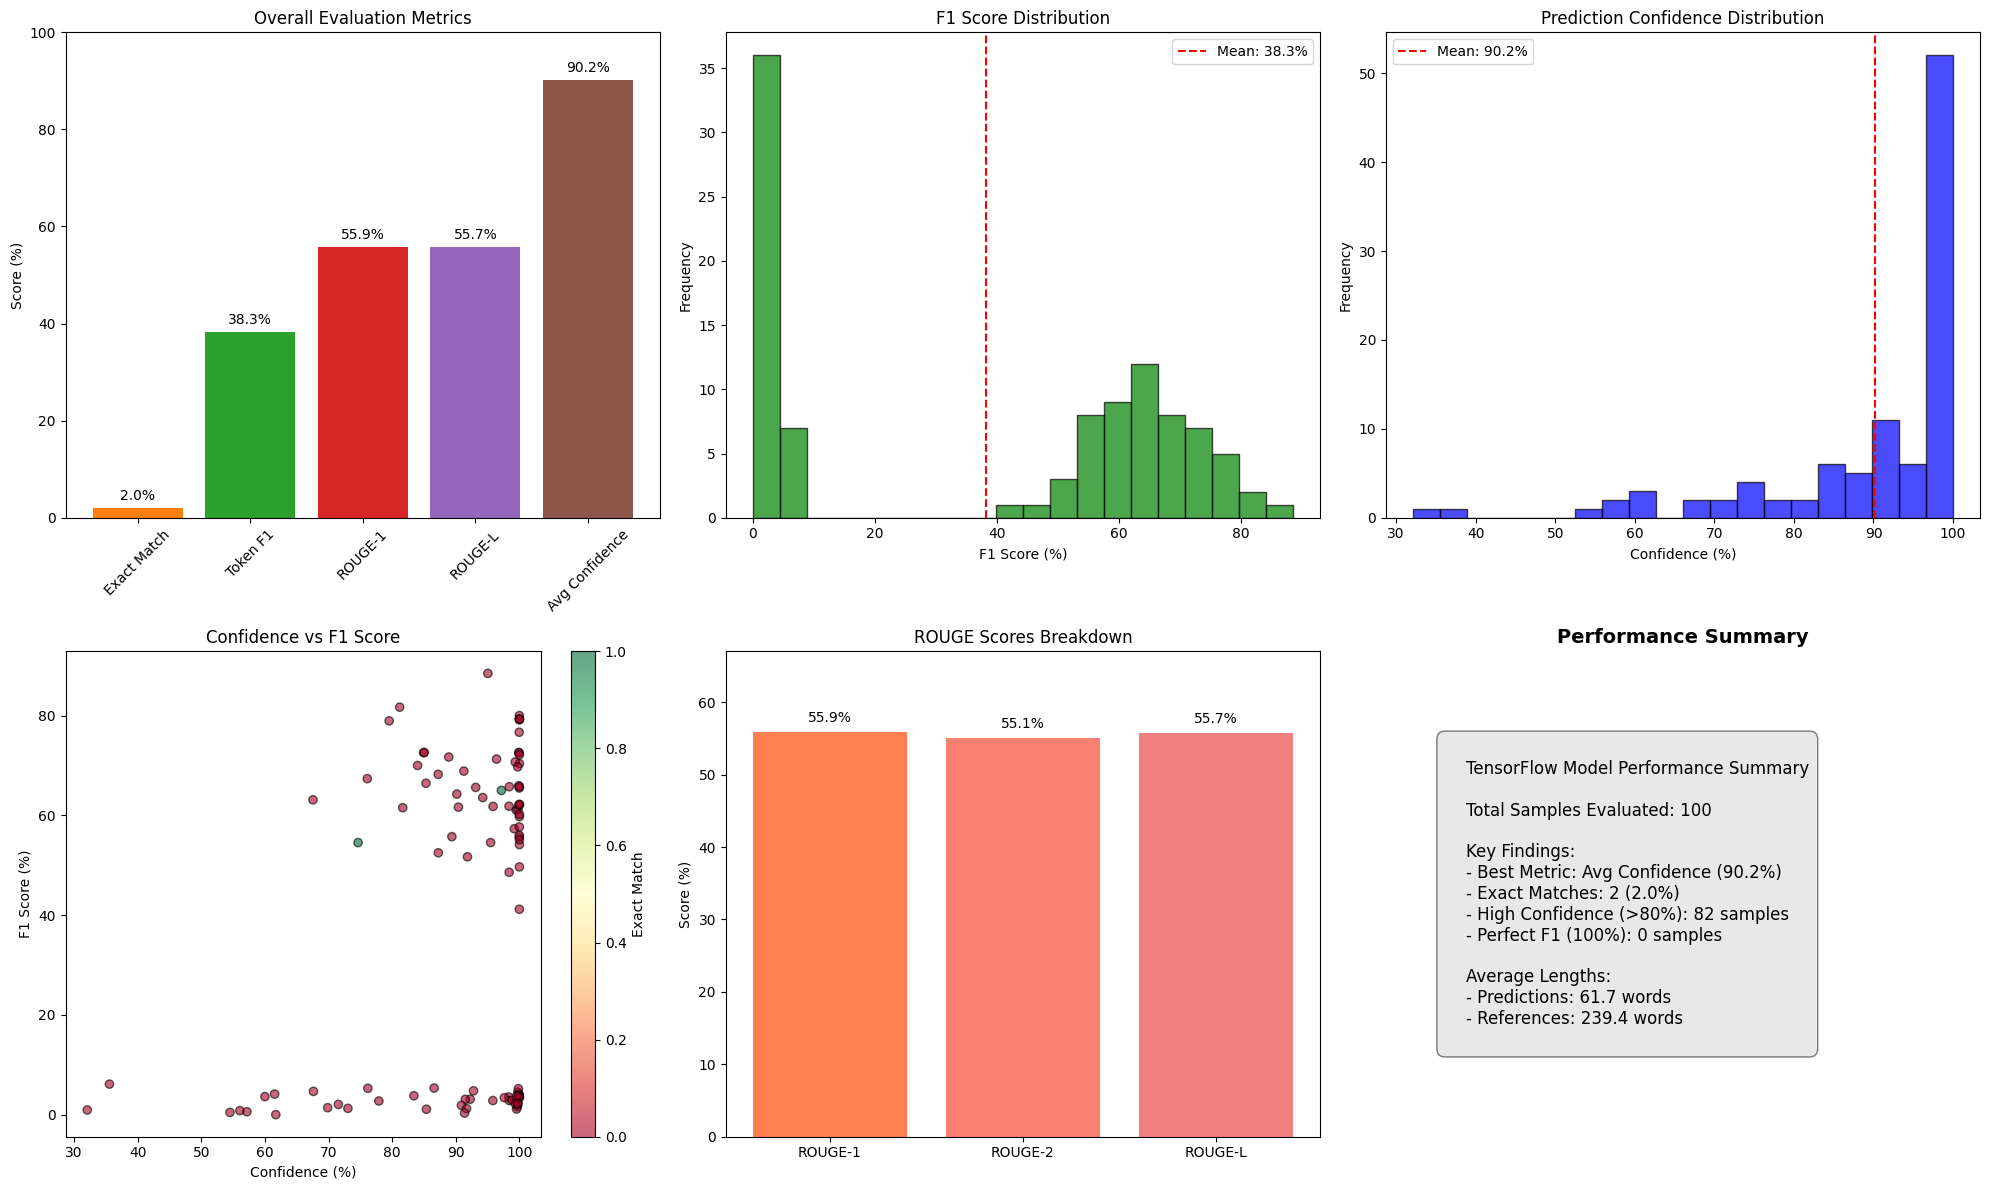

In [197]:
def visualize_evaluation_results(eval_report, f1_scores, confidences, exact_matches):
    """Visualize comprehensive evaluation results"""
    fig = plt.figure(figsize=(20, 12))

    # Overall Metrics Bar Chart
    ax1 = plt.subplot(2, 3, 1)
    metrics_to_plot = ['Exact Match', 'Token F1', 'ROUGE-1', 'ROUGE-L', 'Avg Confidence']
    values = [eval_report[m] for m in metrics_to_plot if eval_report[m] is not None]
    metric_names = [m for m in metrics_to_plot if eval_report[m] is not None]

    bars = ax1.bar(metric_names, values, color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'][:len(values)])
    ax1.set_ylabel('Score (%)')
    ax1.set_title('Overall Evaluation Metrics')
    ax1.set_ylim(0, 100)
    plt.xticks(rotation=45)

    for bar, value in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom')

    # F1 Score Distribution
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(np.array(f1_scores) * 100, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('F1 Score (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('F1 Score Distribution')
    ax2.axvline(np.mean(f1_scores) * 100, color='red', linestyle='--',
                label=f'Mean: {np.mean(f1_scores) * 100:.1f}%')
    ax2.legend()

    # Confidence Distribution
    ax3 = plt.subplot(2, 3, 3)
    ax3.hist(np.array(confidences) * 100, bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax3.set_xlabel('Confidence (%)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Prediction Confidence Distribution')
    ax3.axvline(np.mean(confidences) * 100, color='red', linestyle='--',
                label=f'Mean: {np.mean(confidences) * 100:.1f}%')
    ax3.legend()

    # Confidence vs F1 Scatter
    ax4 = plt.subplot(2, 3, 4)
    scatter = ax4.scatter(np.array(confidences) * 100, np.array(f1_scores) * 100,
                         c=exact_matches, cmap='RdYlGn', alpha=0.6, edgecolors='black')
    ax4.set_xlabel('Confidence (%)')
    ax4.set_ylabel('F1 Score (%)')
    ax4.set_title('Confidence vs F1 Score')
    plt.colorbar(scatter, ax=ax4, label='Exact Match')

    # ROUGE Scores Comparison
    ax5 = plt.subplot(2, 3, 5)
    rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    rouge_values = [eval_report[m] for m in rouge_metrics if eval_report[m] is not None]
    rouge_names = [m for m in rouge_metrics if eval_report[m] is not None]

    if rouge_values:
        ax5.bar(rouge_names, rouge_values, color=['coral', 'salmon', 'lightcoral'][:len(rouge_values)])
        ax5.set_ylabel('Score (%)')
        ax5.set_title('ROUGE Scores Breakdown')
        ax5.set_ylim(0, max(rouge_values) * 1.2)

        for i, value in enumerate(rouge_values):
            ax5.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom')

    # Performance Summary Text
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    valid_metrics = {k: v for k, v in eval_report.items() if v is not None and k in metrics_to_plot}
    best_metric = max(valid_metrics.keys(), key=lambda x: valid_metrics[x]) if valid_metrics else "N/A"

    summary_text = f"""
    TensorFlow Model Performance Summary

    Total Samples Evaluated: {len(f1_scores)}

    Key Findings:
    - Best Metric: {best_metric} ({eval_report.get(best_metric, 0):.1f}%)
    - Exact Matches: {sum(exact_matches)} ({sum(exact_matches)/len(exact_matches)*100:.1f}%)
    - High Confidence (>80%): {sum(c > 0.8 for c in confidences)} samples
    - Perfect F1 (100%): {sum(f == 1.0 for f in f1_scores)} samples

    Average Lengths:
    - Predictions: {eval_report['Avg Pred Length']:.1f} words
    - References: {eval_report['Avg Ref Length']:.1f} words
    """

    ax6.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))
    ax6.set_title('Performance Summary', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run comprehensive evaluation
eval_report, predictions, references = evaluate_model_comprehensive(test_df, num_samples=100)

In [198]:
for metric, value in eval_report.items():
    if value is not None:
        print(f"{metric:.<30} {value:.2f}%")
    else:
        print(f"{metric:.<30} N/A")

Exact Match................... 2.00%
Token F1...................... 38.26%
ROUGE-1....................... 55.85%
ROUGE-2....................... 55.06%
ROUGE-L....................... 55.75%
BERT Score F1................. 90.05%
Avg Confidence................ 90.22%
Avg Pred Length............... 61.67%
Avg Ref Length................ 239.37%


## Testing

In [199]:
print("\nSample Predictions")
test_samples = test_df.head(5)

for idx, row in test_samples.iterrows():
    result = evaluate_extractive_qa_tensorflow(row['question'], row['context'])
    print(f"\nQuestion: {row['question']}")
    print(f"Context: {row['context'][:100]}...")
    print(f"True Answer: {row['answer_text']}")
    print(f"Predicted: {result['answer']}")
    print(f"Confidence: {result['confidence']:.2f}")


Sample Predictions

Question: what is are mevalonate kinase deficiency ?
Context: Patient information shows mevalonate kinase deficiency is a condition characterized by recurrent epi...
True Answer: mevalonate kinase deficiency is a condition characterized by recurrent episodes of fever, which typically begin during infancy. each episode of fever lasts about 3 to 6 days, and the frequency of the episodes varies among affected individuals. in childhood the fevers seem to be more frequent, occurring as often as 25 times a year, but as the individual gets older the episodes occur less often. mevalonate kinase deficiency has additional signs and symptoms, and the severity depends on the type of the condition. there are two types of mevalonate kinase deficiency a less severe type called hyperimmunoglobulinemia d syndrome hids and a more severe type called mevalonic aciduria mva. during episodes of fever, people with hids typically have enlargement of the lymph nodes lymphadenopathy, abdomi

## Creation of the chatbot content inorder to be used in the interface

In [200]:
def find_relevant_context(question, dataset=None):
    """
    Find the most relevant context from the dataset
    """
    if dataset is None:
        return get_medical_context_fallback(question)

    question_lower = question.lower()
    best_match = None
    best_score = 0

    # Search through dataset for relevant contexts
    for idx, row in dataset.iterrows():
        # Check if the question matches
        dataset_question = row.get('question', '').lower()
        dataset_context = row.get('context', '')

        # Simple keyword matching
        question_words = set(question_lower.split())
        dataset_words = set(dataset_question.split())

        # Calculate overlap score
        overlap = len(question_words.intersection(dataset_words))
        score = overlap / max(len(question_words), 1)

        if score > best_score:
            best_score = score
            best_match = dataset_context

    return best_match if best_match else get_medical_context_fallback(question)

def get_medical_context_fallback(question):
    """
    Fallback context generation when dataset search fails
    """
    medical_contexts = {
        "cysticercosis": "Cysticercosis is an infection caused by the larvae of the parasite Taenia solium. This infection occurs after a person swallows tapeworm eggs. The larvae get into tissues such as muscle and brain, and form cysts there.",
        "parasites": "Parasites are organisms that live on or in a host organism and get their food from or at the expense of their host. There are three main types of parasites: protozoa, helminths, and ectoparasites.",
        "diabetes": "Diabetes is a chronic condition affecting blood sugar levels. Type 1 diabetes occurs when the pancreas produces little or no insulin. Type 2 diabetes occurs when the body becomes resistant to insulin or doesn't produce enough.",
        "headache": "Headaches can be primary (like migraines or tension headaches) or secondary (caused by another condition). Common treatments include rest, hydration, over-the-counter pain relievers, and stress management.",
        "blood pressure": "High blood pressure (hypertension) occurs when blood force against artery walls is consistently too high. Normal blood pressure is below 120/80 mmHg.",
        "fever": "Fever is a temporary increase in body temperature, often due to illness. Normal body temperature is around 98.6°F (37°C).",
        "flu": "Influenza (flu) is a respiratory illness caused by influenza viruses. Symptoms include fever, cough, body aches, and fatigue."
    }

    # Find relevant context based on keywords
    question_lower = question.lower()
    for keyword, context in medical_contexts.items():
        if keyword in question_lower:
            return context

    # Default context
    return f"Medical information related to: {question}. This appears to be a medical query that requires professional consultation."

def preprocess_question(question):
    """Clean and normalize the input question"""
    return clean_text(question, remove_stopwords=False)

def answer_medical_question(question, custom_context=None):
    """
    Generate answer using the TensorFlow model
    """
    # Clean the question
    clean_question = preprocess_question(question)

    # Get context from dataset or custom context
    if custom_context:
        context = custom_context
    else:
        context = find_relevant_context(clean_question, train_final_df)

    # Use the TensorFlow evaluation function
    result = evaluate_extractive_qa_tensorflow(clean_question, context)

    # Format response
    if result["confidence"] > 0.8:
        confidence_level = "High confidence"
    elif result["confidence"] > 0.5:
        confidence_level = "Moderate confidence"
    else:
        confidence_level = "Low confidence"

    if result["answer"] and result["answer"].strip():
        return {
            "answer": result["answer"],
            "confidence": result["confidence"],
            "confidence_level": confidence_level,
            "disclaimer": "This information is for educational purposes only. Always consult healthcare professionals for medical advice."
        }
    else:
        return {
            "answer": "I couldn't find a specific answer to your question. Please try rephrasing or providing more context.",
            "confidence": 0.0,
            "confidence_level": "No answer found",
            "disclaimer": "This information is for educational purposes only. Always consult healthcare professionals for medical advice."
        }

def get_session_analytics():
    """Get session analytics placeholder"""
    return {
        "message": "TensorFlow model successfully loaded and ready for questions!",
        "model_type": "TensorFlow/Keras BERT-based QA",
        "total_parameters": f"{model.count_params():,}"
    }

print("TensorFlow Medical QA Bot initialized!")

TensorFlow Medical QA Bot initialized!


## Gradio interface for now

In [201]:
def create_gradio_interface_tensorflow():
    """
    Create a professional, user-friendly Gradio interface for the TensorFlow medical chatbot.
    """

    custom_css = """
    .gradio-container {
        font-family: 'Arial', sans-serif;
        background-color: #1A1B41;
    }
    .gr-button-primary {
        background-color: #2e7d32 !important;
        border-radius: 8px !important;
    }
    .gr-button-primary:hover {
        background-color: #1b5e20 !important;
    }
    .disclaimer {
        background-color: #fff3cd;
        border: 1px solid #ffeaa7;
        border-radius: 5px;
        padding: 10px;
        margin: 10px 0;
        color: #664d03;
    }
    """

    def gradio_chat_function(question, chat_history, provide_context=None):
        """
        Process user questions and maintain chat history in the Gradio interface.
        """
        if not question.strip():
            return "", chat_history

        try:
            # Get response from TensorFlow chatbot
            response_dict = answer_medical_question(question, custom_context=provide_context if provide_context else None)

            # Format the response with confidence information
            formatted_response = f"""
**Answer:** {response_dict['answer']}

**Confidence Level:** {response_dict['confidence_level']} ({response_dict['confidence']:.1%})

---
*{response_dict['disclaimer']}*
            """

            # Update chat history
            chat_history.append([question, formatted_response])

        except Exception as e:
            # Handle any errors gracefully
            error_response = f"Sorry, I encountered an error processing your question: {str(e)}"
            chat_history.append([question, error_response])

        return "", chat_history

    def get_analytics_display():
        """Get analytics in a formatted string"""
        try:
            analytics = get_session_analytics()
            if isinstance(analytics, dict):
                formatted_analytics = "TensorFlow Model Analytics\n\n"
                for key, value in analytics.items():
                    formatted_key = key.replace('_', ' ').title()
                    formatted_analytics += f"• **{formatted_key}:** {value}\n"
                return formatted_analytics
            else:
                return f"Model Analytics\n\n{analytics}"
        except Exception as e:
            return f"Analytics unavailable: {str(e)}"

    # Example questions to help users understand chatbot capabilities
    example_questions = [
        "What are the symptoms of diabetes?",
        "How can I treat a headache naturally?",
        "What causes high blood pressure?",
        "What are the side effects of aspirin?",
        "How can I prevent the flu?",
        "What should I do if I have a fever?",
        "What are the signs of dehydration?",
        "How much water should I drink daily?"
    ]

    # Build the interface with all components
    with gr.Blocks(theme=gr.themes.Soft(), css=custom_css, title="TensorFlow Medical Q&A Assistant") as interface:
        # Header section
        gr.Markdown(
            """
            # TensorFlow Medical Q&A Assistant

            ### About This System
            This AI-powered medical chatbot uses a **TensorFlow/Keras implementation** of BERT for extractive question answering.
            It's designed to provide quick, accurate answers to common medical questions by extracting information from medical knowledge.

            ### Model Details
            - **Framework**: TensorFlow/Keras with TensorFlow Hub
            - **Base Model**: BERT (bert_en_uncased_L-12_H-768_A-12)
            - **Task**: Extractive Question Answering
            - **Training**: Fine-tuned on medical Q&A dataset

            ### How to Use
            1. Type your medical question in the text box below
            2. Optionally provide additional context for more specific answers
            3. Click "Get Answer" or press Enter to get your answer
            4. View the confidence level to understand answer reliability

            ### Important Disclaimer
            <div class="disclaimer">
            <strong>This chatbot is for educational and informational purposes only.</strong> It should NOT replace professional
            medical advice, diagnosis, or treatment. Always consult with qualified healthcare providers for medical concerns.
            </div>
            """
        )

        # Main interface layout
        with gr.Row():
            with gr.Column(scale=1):
                # Question input
                question_input = gr.Textbox(
                    label="Your Medical Question",
                    placeholder="Example: What are the symptoms of diabetes?",
                    lines=3,
                    info="Type your medical question here. Be as specific as possible."
                )

                # Optional context input
                context_input = gr.Textbox(
                    label="Additional Context (Optional)",
                    placeholder="Provide any additional medical context or specific information...",
                    lines=2,
                    info="Add any relevant medical history or specific details"
                )

                # Submit and clear buttons
                with gr.Row():
                    submit_btn = gr.Button("Get Answer", variant="primary", scale=2)
                    clear_btn = gr.Button("Clear", scale=1)

                # Example questions
                gr.Markdown("### Example Questions")
                with gr.Row():
                    with gr.Column():
                        for i in range(0, 4):
                            btn = gr.Button(example_questions[i], size="sm")
                            btn.click(
                                fn=lambda x=example_questions[i]: x,
                                outputs=question_input
                            )

                    with gr.Column():
                        for i in range(4, 8):
                            btn = gr.Button(example_questions[i], size="sm")
                            btn.click(
                                fn=lambda x=example_questions[i]: x,
                                outputs=question_input
                            )

                # Session analytics
                analytics_display = gr.Markdown(
                    value=get_analytics_display(),
                    label="Model Analytics"
                )

            # Chat history
            with gr.Column(scale=2):
                chatbot_ui = gr.Chatbot(
                    label="Conversation History",
                    height=600,
                    elem_classes="chatbot-container"
                )

        # Additional information
        with gr.Accordion("TensorFlow Implementation Details", open=False):
            gr.Markdown(
                """
                ### Technical Architecture
                - **Input Processing**: BERT WordPiece tokenization with 256 max sequence length
                - **Model Architecture**:
                  - Pre-trained BERT from TensorFlow Hub
                  - Custom QA head with dense layer for start/end position prediction
                  - Trainable parameters: 110M+
                - **Training Setup**:
                  - Adam optimizer with 3e-5 learning rate
                  - Custom training loop with @tf.function for optimization
                  - Gradient accumulation and mixed precision support

                ### Preprocessing Features
                1. **Medical Text Cleaning**: Preserves medical-specific punctuation and terminology
                2. **Smart Stopword Handling**: Keeps medically important words like "not", "can", "should"
                3. **Context Generation**: Creates appropriate contexts for extractive QA
                4. **Data Augmentation**: Multiple context variations for robust training

                ### Evaluation Metrics
                - **Exact Match Score**: Percentage of perfect answer matches
                - **Token F1 Score**: Overlap-based scoring at word level
                - **ROUGE Scores**: Text similarity metrics (ROUGE-1, ROUGE-2, ROUGE-L)
                - **BERT Score**: Semantic similarity using contextual embeddings
                - **Confidence Calibration**: Model uncertainty quantification

                ### Deployment Advantages
                - **TensorFlow Serving**: Ready for production API deployment
                - **TensorFlow Lite**: Mobile and edge device compatibility
                - **Cloud Integration**: Native support for GCP, AWS, Azure
                - **Model Optimization**: Quantization and pruning ready

                ### Limitations
                - Cannot diagnose medical conditions
                - Answers based on training data only
                - May not include latest medical research
                - Should not be used for emergency medical situations
                - For emergencies, call your local emergency number immediately
                """
            )

        # Event handlers
        def clear_interface():
            """Clear all inputs and optionally reset chat history"""
            return "", "", []

        def update_analytics():
            """Update analytics display"""
            return get_analytics_display()

        # Connect buttons to functions
        submit_btn.click(
            fn=gradio_chat_function,
            inputs=[question_input, chatbot_ui, context_input],
            outputs=[question_input, chatbot_ui]
        ).then(
            fn=update_analytics,
            outputs=analytics_display
        )

        question_input.submit(
            fn=gradio_chat_function,
            inputs=[question_input, chatbot_ui, context_input],
            outputs=[question_input, chatbot_ui]
        ).then(
            fn=update_analytics,
            outputs=analytics_display
        )

        clear_btn.click(
            fn=clear_interface,
            outputs=[question_input, context_input, chatbot_ui]
        ).then(
            fn=update_analytics,
            outputs=analytics_display
        )

    return interface

# Launch Gradio interface
print("LAUNCHING TENSORFLOW GRADIO INTERFACE")

try:
    gradio_interface = create_gradio_interface_tensorflow()
    gradio_interface.launch(
        share=True,  # Creates public link
        debug=False,
        server_name="0.0.0.0",
        server_port=None,
        show_error=True
    )
    print("TensorFlow Gradio interface launched successfully!")
    print("Access the public URL shown above to use the TensorFlow chatbot")

except Exception as e:
    print(f"Error launching Gradio: {e}")
    print("You can still use the chatbot programmatically:")

    # Provide fallback usage examples
    print("\nExample usage:")
    print("response = answer_medical_question('What are the symptoms of diabetes?')")
    print("print(response)")

    # Test the TensorFlow model
    print("\n=== Testing TensorFlow Model ===")
    test_questions = [
        "What are the symptoms of diabetes?",
        "How can I treat a headache?",
        "What causes high blood pressure?"
    ]

    for question in test_questions:
        response = answer_medical_question(question)
        print(f"\nQ: {question}")
        print(f"A: {response['answer']}")
        print(f"Confidence: {response['confidence']:.2f} ({response['confidence_level']})")

LAUNCHING TENSORFLOW GRADIO INTERFACE
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://db88595981f95d38af.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


TensorFlow Gradio interface launched successfully!
Access the public URL shown above to use the TensorFlow chatbot
